
# WVS Wave 7 Data Analysis - Alternate Imputation (Default IterativeImputer)
- This script performs data imputation using a demographic grouping strategy.
- It applies scikit-learn's default IterativeImputer within each group,
- followed by post-processing (rounding/clipping) and a fallback SimpleImputer.
- It reads data pre-processed by the initial cleaning/manual imputation script.

In [ ]:
# =============================================================================
# Imports
# =============================================================================
import pathlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For potential post-analysis plots
import seaborn as sns # For potential post-analysis plots
from tqdm import tqdm # Progress bars

# Scikit-learn for imputation
from sklearn.experimental import enable_iterative_imputer  # noqa: F401 # Enable experimental feature
from sklearn.impute import IterativeImputer, SimpleImputer

# Filter warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [2]:
# =============================================================================
# Configuration / Constants
# =============================================================================
DATA_DIR = pathlib.Path("./data")

# --- Input Data ---
# Assumes the output from the first pre-processing script is saved here
PREPROCESSED_DATA_PATH = DATA_DIR / "wvs_wave7_preprocessed.csv"

# --- Output Data ---
IMPUTED_OUTPUT_CSV_PATH = DATA_DIR / "wvs_wave7_imputed.csv"

In [ ]:
# --- Imputation Parameters ---
# Demographic variables used for grouping during imputation
IMPUTATION_DEMOGRAPHIC_VARS = [
    'B_COUNTRY_ALPHA', # country (Required if used later for analysis)
    'H_URBRURAL',      # urban / rural
    # 'Q273',          # marital status (Example - commented out)
    'Q260',            # sex
    'X003R2',          # age (3-cat)
    'Q275R',           # education (3 groups)
    # 'Q279',          # employment (Example - commented out)
]
DEMOGRAPHIC_GROUP_COLUMN = 'demographic_group' # Name for the generated group key column

# IterativeImputer Parameters (using defaults here)
MICE_MAX_ITER = 10
MICE_RANDOM_STATE = 42

# Fallback Imputation Strategy
FALLBACK_STRATEGY = 'most_frequent' # Options: 'mean', 'median', 'most_frequent'

In [ ]:
# --- Post-Analysis Configuration  ---
COUNTRY_COLUMN = 'B_COUNTRY_ALPHA' # For post-imputation analysis by country
RUN_POST_IMPUTATION_ANALYSIS = True # False to skip analysis plots
MISSING_THRESHOLDS_POST_IMPUTATION = [0.1, 1, 5, 10, 25]
HEATMAP_CHUNK_SIZE_POST_IMPUTATION = 20
POST_IMPUTATION_SUMMARY_PLOT_PATH = DATA_DIR / 'missing_data_summary_post_imputation_alternate.png'
POST_IMPUTATION_DETAIL_PLOT_BASE = DATA_DIR / 'missing_data_heatmap_post_imputation_alternate_part_'


In [ ]:
# =============================================================================
# Function Definitions
# =============================================================================

def load_preprocessed_data(filepath: pathlib.Path) -> pd.DataFrame:
    """Loads the pre-processed data CSV file."""
    print(f"Loading preprocessed data from: {filepath}")
    if not filepath.exists():
        raise FileNotFoundError(
            f"Error: Preprocessed data file not found at '{filepath}'. "
            "Please ensure the first script ran successfully and saved the file."
        )
    df = pd.read_csv(filepath)
    print(f"Loaded preprocessed data shape: {df.shape}")

    # Basic check for demographic columns needed for grouping
    missing_req_cols = [col for col in IMPUTATION_DEMOGRAPHIC_VARS if col not in df.columns]
    if missing_req_cols:
         raise ValueError(f"Error: Required demographic columns missing from preprocessed data: {missing_req_cols}")
    return df

def create_demographic_groups(df: pd.DataFrame, demographic_vars: list[str], group_col_name: str) -> tuple[pd.DataFrame, list]:
    """Creates a unique key for each combination of demographic variables."""
    print(f"Creating demographic group keys using variables: {demographic_vars}")

    # Check if specified demographic variables exist
    valid_demo_vars = [var for var in demographic_vars if var in df.columns]
    if len(valid_demo_vars) < len(demographic_vars):
        print(f"Warning: Not all specified demographic vars found. Using: {valid_demo_vars}")
    if not valid_demo_vars:
         raise ValueError("Error: No valid demographic variables found for grouping.")

    def create_group_key(row):
        # To handle potential NaNs in grouping variables by converting them to a string 'missing'
        vals = [
            "missing" if pd.isna(row[v]) else str(int(row[v])) if pd.api.types.is_numeric_dtype(row[v]) else str(row[v])
            for v in valid_demo_vars # Use only valid vars found
        ]
        return "_".join(vals)

    df[group_col_name] = df.apply(create_group_key, axis=1)
    groups = df[group_col_name].unique().tolist()
    print(f"Created {len(groups)} unique demographic groups.")
    return df, groups

def post_process_imputed_values(df_imputed: pd.DataFrame, df_original_group: pd.DataFrame) -> pd.DataFrame:
    """Rounds and clips imputed values based on original group data ranges."""
    processed_df = df_imputed.copy()
    imputation_cols = df_imputed.columns # Columns that were imputed

    for col in imputation_cols:
        if col not in df_original_group.columns:
            continue # Should not happen if logic is correct, but just a safety check

        original_series = df_original_group[col].dropna()

        # Round to the nearest integer (assuming underlying data is ordinal/count)
        # Can be adjusted if continuous data where rounding is not desired
        processed_df[col] = np.round(processed_df[col]).astype(int) # Cast to int after rounding

        # To ensure values stay within the original range observed in the group
        if not original_series.empty:
            min_val = original_series.min()
            max_val = original_series.max()
            processed_df[col] = processed_df[col].clip(min_val, max_val)
        else:
            # If original group had no data for this column, we can't clip based on range.
            # Options: Apply a global min/max if available, or leave as is.
            # print(f"Warning: Cannot determine range for clipping column '{col}' - original group had no data.")
            pass # Currently leaves rounded value as is

    return processed_df


def impute_groups_iterative(df_grouped: pd.DataFrame, group_col_name: str, groups: list,
                            demographic_vars: list[str]) -> pd.DataFrame:
    """Performs default Iterative Imputation within each demographic group."""
    print(f"\nStarting imputation process across {len(groups)} demographic groups...")
    processed_group_dfs = [] # Store processed group DataFrames here

    # Identify columns that are *not* demographic identifiers
    all_columns = df_grouped.columns.tolist()
    columns_for_imputation_pool = [
        col for col in all_columns if col not in demographic_vars and col != group_col_name
    ]
    if not columns_for_imputation_pool:
         raise ValueError("Error: No columns identified for imputation after excluding demographics.")

    # Iterate through each demographic group with a progress bar
    for group_key in tqdm(groups, desc="Processing demographic groups"):
        group_data = df_grouped.loc[df_grouped[group_col_name] == group_key].copy()
        group_ids = group_data[demographic_vars].copy() # Keep demographic identifiers aside

        # Data potentially needing imputation (non-demographic columns)
        X_group_potential = group_data[columns_for_imputation_pool].copy()

        # --- Sanity Checks ---
        if len(group_data) <= 1:
            # print(f"   - Group {group_key}: Skipped (<= 1 record)")
            processed_group_dfs.append(group_data.drop(columns=[group_col_name])) # Add original group data
            continue
        if not X_group_potential.isnull().any().any():
            # print(f"   - Group {group_key}: Skipped (No missing data)")
            processed_group_dfs.append(group_data.drop(columns=[group_col_name])) # Add original group data
            continue

        # --- To prepare for Imputation ---
        # Identify columns entirely missing *within this group*
        all_missing_in_group = X_group_potential.columns[X_group_potential.isnull().all()].tolist()
        imputation_cols_this_group = [
            col for col in columns_for_imputation_pool if col not in all_missing_in_group
        ]

        # Skip if no columns left to impute
        if not imputation_cols_this_group:
             # print(f"   - Group {group_key}: Skipped (No columns with data to impute)")
             processed_group_dfs.append(group_data.drop(columns=[group_col_name])) # Add original group data
             continue

        X_group_imp = X_group_potential[imputation_cols_this_group].copy()

        # --- Perform Imputation ---
        # print(f"   - Group {group_key}: Running MICE on {X_group_imp.shape[1]} variables for {X_group_imp.shape[0]} records...")
        try:
            # Using default IterativeImputer OR, BayesianRidge (Patata Potato)
            imputer = IterativeImputer(
                random_state=MICE_RANDOM_STATE,
                max_iter=MICE_MAX_ITER,
                skip_complete=True,
                add_indicator=False
                    # Fit and transformata is numeric
            X_group_imp_numeric = X_group_imp.apply(pd.to_numeric, errors='coerce')

            # Fit and transform
            imputed_data_np = imputer.fit_transform(X_group_imp_numeric)

            # Convert back to DataFrame
            X_complete_group = pd.DataFrame(
                imputed_data_np,
                columns=imputation_cols_this_group, # Use the actual cols imputed
                index=X_group_imp.index
            )

            # --- Post-Process and Combine ---
            X_complete_group = post_process_imputed_values(X_complete_group, group_data)

            # Add back any columns that were all missing (as NaNs)
            if all_missing_in_group:
                for col in all_missing_in_group:
                    X_complete_group[col] = np.nan

            # Re-attach demographic identifiers
            # Ensure columns align: use original pool order, reindexed
            final_group_df = pd.concat([
                group_ids.reset_index(drop=True), # Ensures index alignment
                X_complete_group.reset_index(drop=True) # Ensures index alignment
                ], axis=1)
            # Reorder columns to original non-group-key order + demographics
            final_group_df = final_group_df.reindex(columns=group_ids.columns.tolist() + columns_for_imputation_pool)
            processed_group_dfs.append(final_group_df)
            # print(f"   - Group {group_key}: Completed processing.")

        except Exception as e:
            print(f"   - Group {group_key}: ERROR during imputation - {e}")
            print(f"     Keeping original data for this group.")
            processed_group_dfs.append(group_data.drop(columns=[group_col_name])) # Add original group data on error

    # --- Final Assembly ---
    if not processed_group_dfs:
         print("Warning: No groups were processed. Returning empty DataFrame.")
         return pd.DataFrame()

    print("\nConcatenating results from all groups...")
    imputed_data_full = pd.concat(processed_group_dfs, ignore_index=True)
    print(f"Imputation complete! Processed {len(groups)} demographic groups.")
    print(f"Shape after group-wise imputation: {imputed_data_full.shape}")

    return imputed_data_full


def fallback_imputation(df: pd.DataFrame, demographic_vars: list[str], strategy: str) -> pd.DataFrame:
    """Applies SimpleImputer to any remaining missing values in non-demographic columns."""
    print(f"\nApplying fallback imputation (strategy: {strategy}) for remaining NaNs...")
    df_copy = df.copy() # Work on a copy

    # Identify columns with missing data, excluding demographics
    cols_with_nan = df_copy.columns[df_copy.isnull().any()].tolist()
    cols_to_fallback_impute = [
        col for col in cols_with_nan if col not in demographic_vars
    ]

    if not cols_to_fallback_impute:
        print("No remaining NaNs found in non-demographic columns. Skipping fallback imputation.")
        return df_copy

    print(f"Found {len(cols_to_fallback_impute)} columns for fallback imputation: {cols_to_fallback_impute}")

    try:
        si = SimpleImputer(strategy=strategy)
        # To ensure only valid columns are passed to fit_transform
        valid_cols_to_impute = [col for col in cols_to_fallback_impute if col in df_copy.columns]
        if valid_cols_to_impute:
             df_copy[valid_cols_to_impute] = si.fit_transform(df_copy[valid_cols_to_impute])
             print(f"Fallback imputation completed using {strategy}.")
        else:
             print("No valid columns found to apply fallback imputation.")

    except Exception as e:
        print(f"Error during fallback imputation: {e}. Some NaNs might remain.")

    return df_copy

def check_missing_values(df: pd.DataFrame, stage_name: str):
    """Checks and reports remaining missing values."""
    print(f"\n--- Checking missing values after {stage_name} ---")
    missing_counts = df.isnull().sum()
    missing_cols = missing_counts[missing_counts > 0]

    if missing_cols.empty:
        print("No missing values found.")
    else:
        print("Remaining missing values found:")
        print(missing_cols)
    print("-" * (len(stage_name) + 30))


def save_data(df: pd.DataFrame, filepath: pathlib.Path):
    """Saves the DataFrame to a CSV file."""
    print(f"\nSaving imputed data to: {filepath}")
    try:
        # Ensure directory exists
        filepath.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(filepath, index=False)
        print(f"Successfully saved {filepath} ({df.shape[0]:,} rows × {df.shape[1]} cols)")
    except Exception as e:
        print(f"Error saving data to {filepath}: {e}")


def analyze_within_country_missing(data: pd.DataFrame, country_col: str, thresholds: list[int]) -> pd.DataFrame:
    """Analyzes missing data percentages within each country for different thresholds."""
    print(f"\nAnalyzing missing data within each country for thresholds: {thresholds}%...")

    # Calculate missing data percentage by country and column
    missing_by_country = data.groupby(country_col).apply(
        lambda x: x.drop(country_col, axis=1).isnull().mean() * 100
    )

    # Identify columns meeting thresholds for each country
    country_missing_analysis = {}
    for country in missing_by_country.index:
        country_data = missing_by_country.loc[country]
        country_analysis = {f"≥{t}%_missing": country_data[country_data >= t].index.tolist() for t in thresholds}
        country_missing_analysis[country] = country_analysis

    # Create a summary table
    summary_data = []
    for country, analysis in country_missing_analysis.items():
        row = {'Country': country}
        row.update({f"≥{t}%_missing": len(analysis[f"≥{t}%_missing"]) for t in thresholds})
        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data).set_index('Country')
    # Sort by the highest threshold count (eg: 100%) descending
    summary_df = summary_df.sort_values(by=f"≥{thresholds[-1]}%_missing", ascending=False)

    print("\n=== Summary of Columns with Missing Data by Country (%) ===")
    print(summary_df)

    # Return the detailed breakdown by country/column for plotting
    return summary_df, missing_by_country

def visualize_missing_data_summary(summary_df: pd.DataFrame, filename: str = 'missing_data_summary_by_country.png'):
    """Generates a heatmap summarizing missing column counts per country."""
    print("\nGenerating summary heatmap of missing data counts...")
    plt.figure(figsize=(12, max(6, len(summary_df) * 0.3))) # Adjust height based on number of countries
    sns.heatmap(summary_df, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
    plt.title('Number of Columns with ≥ Threshold % Missing Data by Country')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved summary heatmap to: {filename}")
    plt.show()

def visualize_missing_data_details(missing_by_country_df: pd.DataFrame, chunk_size: int, base_filename: str = 'missing_data_heatmap_part_'):
    """Generates detailed heatmaps of missing percentages in chunks."""
    print(f"\nGenerating detailed heatmaps of missing percentages (chunk size: {chunk_size})...")
    num_cols = missing_by_country_df.shape[1]
    num_countries = missing_by_country_df.shape[0]

    for i in range(0, num_cols, chunk_size):
        end = min(i + chunk_size, num_cols)
        chunk_data = missing_by_country_df.iloc[:, i:end]
        part_num = i // chunk_size + 1
        filename = f"{base_filename}{part_num}.png"

        plt.figure(figsize=(min(25, chunk_data.shape[1] * 0.8), max(8, num_countries * 0.25))) # Adjust size dynamically
        sns.heatmap(chunk_data, cmap='YlOrRd', vmin=0, vmax=100,
                    linewidths=0.5, linecolor='lightgray', cbar_kws={'label': '% Missing Data'})
        plt.title(f'Percentage of Missing Data by Country (Columns {i+1}-{end})')
        plt.ylabel('Country Code')
        plt.xlabel('Survey Questions/Columns')
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved detailed heatmap chunk {part_num} to: {filename}")
        plt.show()


In [6]:
# =============================================================================
# Main Execution Workflow
# =============================================================================

def main():
    """Main function to orchestrate the alternate imputation pipeline."""
    print("--- Starting WVS Data Alternate Imputation Pipeline ---")

    try:
        # 1. Load Preprocessed Data
        df_preprocessed = load_preprocessed_data(PREPROCESSED_DATA_PATH)

        # 2. Create Demographic Groups
        df_grouped, groups = create_demographic_groups(
            df_preprocessed, IMPUTATION_DEMOGRAPHIC_VARS, DEMOGRAPHIC_GROUP_COLUMN
        )

        # 3. Perform Imputation Within Groups (using default IterativeImputer)
        df_imputed_groups = impute_groups_iterative(
            df_grouped, DEMOGRAPHIC_GROUP_COLUMN, groups,
            IMPUTATION_DEMOGRAPHIC_VARS
        )
        check_missing_values(df_imputed_groups, "Group-wise Iterative Imputation")

        # 4. Apply Fallback Imputation
        df_final_imputed = fallback_imputation(
            df_imputed_groups, IMPUTATION_DEMOGRAPHIC_VARS, FALLBACK_STRATEGY
        )
        check_missing_values(df_final_imputed, "Fallback Imputation")

        # 5. Save Final Imputed Data
        save_data(df_final_imputed, IMPUTED_OUTPUT_CSV_PATH)

        # 6. Post-Imputation Missing Data Analysis (Optional)
        if RUN_POST_IMPUTATION_ANALYSIS:
            print("\n--- Performing Post-Imputation Missing Data Analysis ---")
            if COUNTRY_COLUMN in df_final_imputed.columns:
                try:
                    summary_df_post, details_df_post = analyze_within_country_missing(
                        df_final_imputed, COUNTRY_COLUMN, MISSING_THRESHOLDS_POST_IMPUTATION
                    )
                    visualize_missing_data_summary(
                        summary_df_post,
                        filename=str(POST_IMPUTATION_SUMMARY_PLOT_PATH)
                    )
                    visualize_missing_data_details(
                        details_df_post,
                        chunk_size=HEATMAP_CHUNK_SIZE_POST_IMPUTATION,
                        base_filename=str(POST_IMPUTATION_DETAIL_PLOT_BASE)
                    )
                except NameError as e:
                    print(f"Could not run post-imputation analysis: Required function not found ({e}).")
                    print("Ensure analysis functions are defined or imported.")
                except Exception as e:
                    print(f"An error occurred during post-imputation analysis: {e}")
            else:
                print(f"Skipping post-imputation analysis by country: Column '{COUNTRY_COLUMN}' not found.")

        print("\n--- WVS Data Alternate Imputation Pipeline Finished ---")

    except FileNotFoundError as e:
        print(f"\nCritical Error: Input file not found.")
        print(e)
    except ValueError as e:
        print(f"\nCritical Error: Configuration or Data invalid.")
        print(e)
    except Exception as e:
        print(f"\nAn unexpected error occurred during the pipeline execution:")
        print(e)
        # import traceback
        # traceback.print_exc() # Uncomment for detailed error traceback

--- Starting WVS Data Alternate Imputation Pipeline ---
Loading preprocessed data from: data\wvs_wave7_preprocessed.csv
Loaded preprocessed data shape: (97220, 102)
Creating demographic group keys using variables: ['B_COUNTRY_ALPHA', 'H_URBRURAL', 'Q260', 'X003R2', 'Q275R']
Created 2676 unique demographic groups.

Starting imputation process across 2676 demographic groups...


Processing demographic groups: 100%|██████████| 2676/2676 [29:30<00:00,  1.51it/s]  



Concatenating results from all groups...
Imputation complete! Processed 2676 demographic groups.
Shape after group-wise imputation: (97220, 102)

--- Checking missing values after Group-wise Iterative Imputation ---
Remaining missing values found:
H_URBRURAL      37
Q260            95
X003R2         511
Q275R         1071
Q106            18
              ... 
Q73P            38
Q77P            48
Q8P             11
Q90             31
Q9P              5
Length: 101, dtype: int64
-------------------------------------------------------------

Applying fallback imputation (strategy: most_frequent) for remaining NaNs...
Found 97 columns for fallback imputation: ['Q106', 'Q107', 'Q108', 'Q109', 'Q110', 'Q111', 'Q112', 'Q11P', 'Q121', 'Q123', 'Q124', 'Q12P', 'Q130P', 'Q149', 'Q150', 'Q151P', 'Q15P', 'Q160', 'Q162', 'Q163', 'Q164', 'Q165P', 'Q166P', 'Q169P', 'Q16P', 'Q170P', 'Q171P', 'Q172P', 'Q173P', 'Q176P', 'Q17P', 'Q180', 'Q182', 'Q184', 'Q185', 'Q186', 'Q188', 'Q189', 'Q190', 'Q195', 'Q1

C:\Users\singh\AppData\Local\Temp\ipykernel_24744\634274217.py:245: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby(country_col).apply(



=== Summary of Columns with Missing Data by Country (%) ===
         ≥0.1%_missing  ≥1%_missing  ≥5%_missing  ≥10%_missing  ≥25%_missing
Country                                                                     
AND                  0            0            0             0             0
ARG                  0            0            0             0             0
ARM                  1            0            0             0             0
AUS                  4            1            0             0             0
BGD                  0            0            0             0             0
...                ...          ...          ...           ...           ...
USA                  1            1            0             0             0
UZB                  1            1            0             0             0
VEN                  0            0            0             0             0
VNM                  0            0            0             0             0
ZWE            

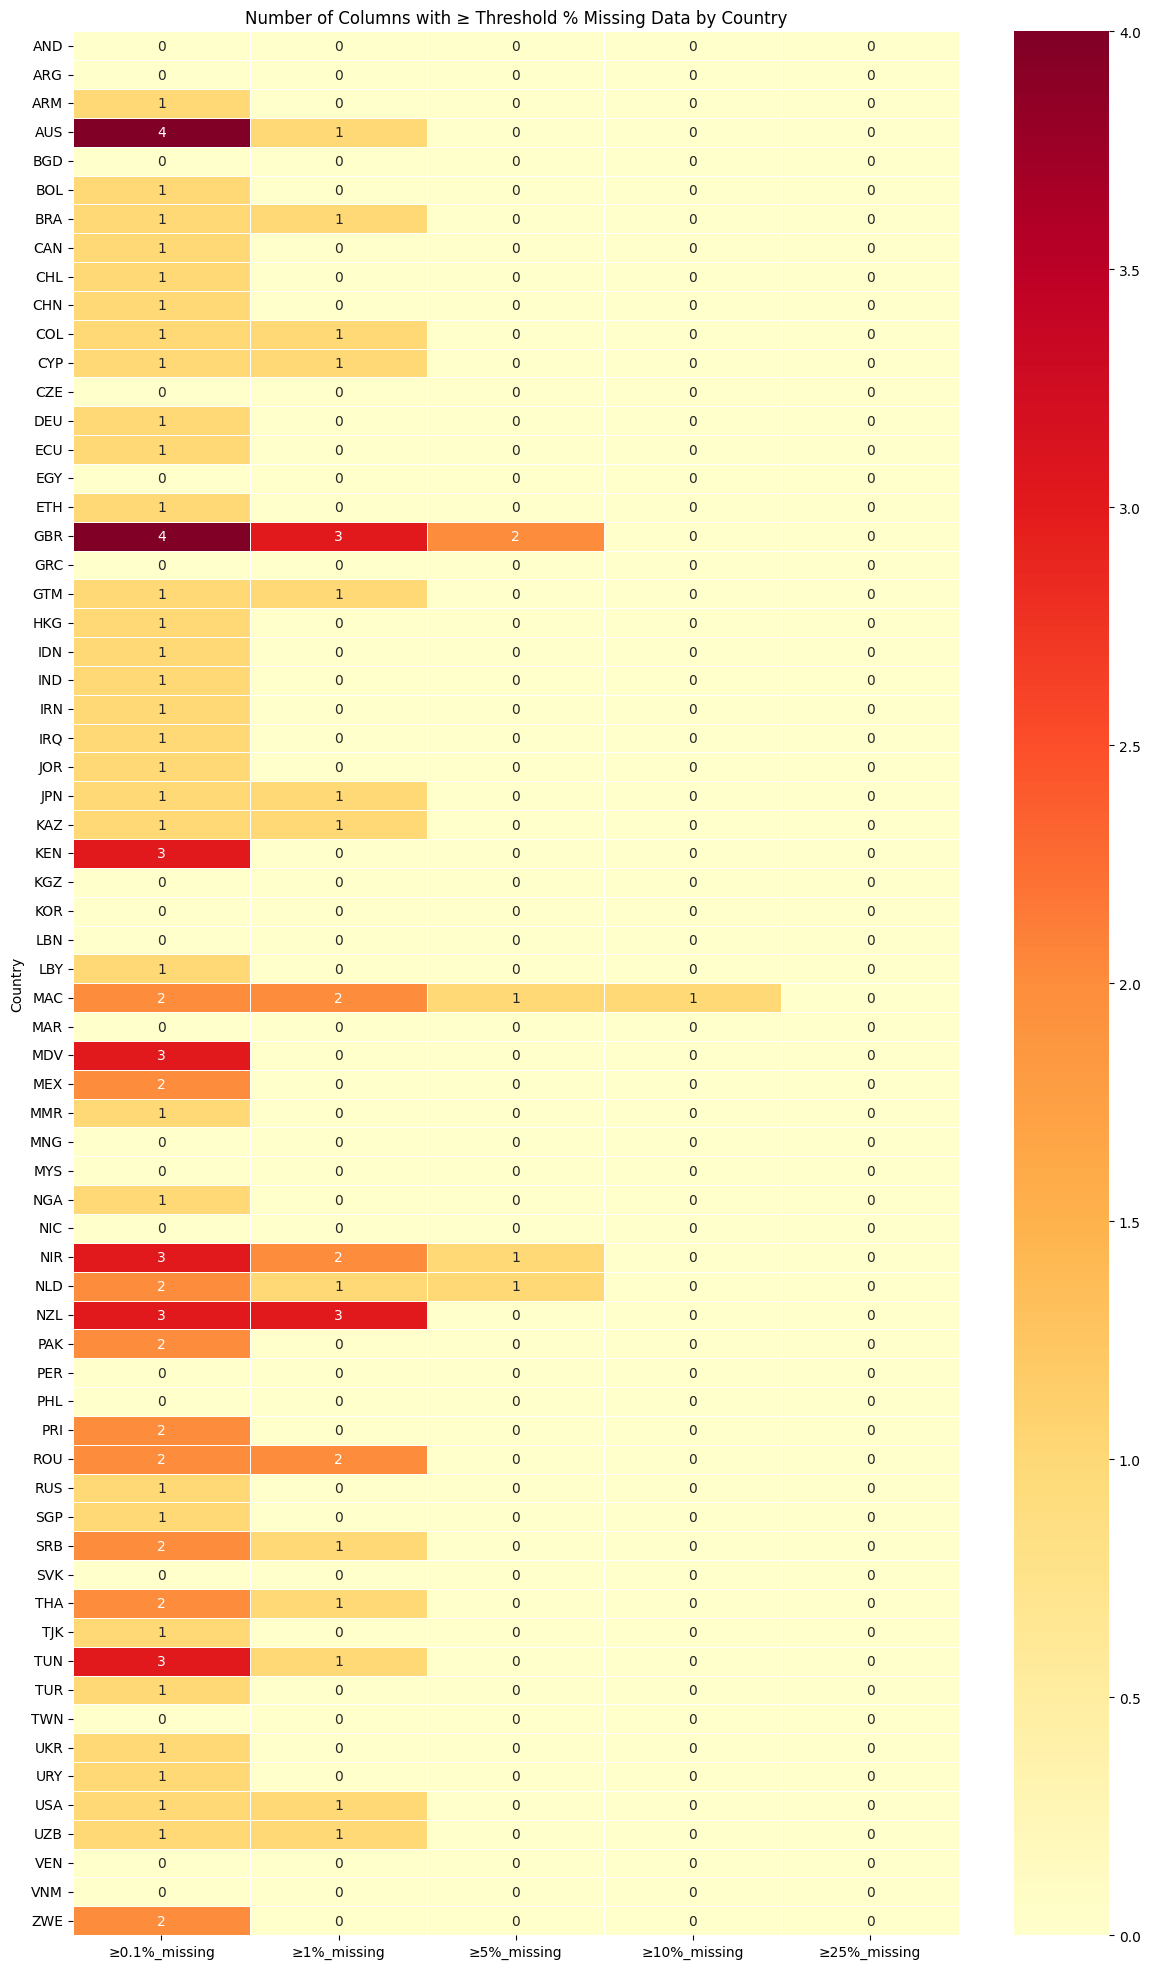


Generating detailed heatmaps of missing percentages (chunk size: 20)...
Saved detailed heatmap chunk 1 to: data\missing_data_heatmap_post_imputation_alternate_part_1.png


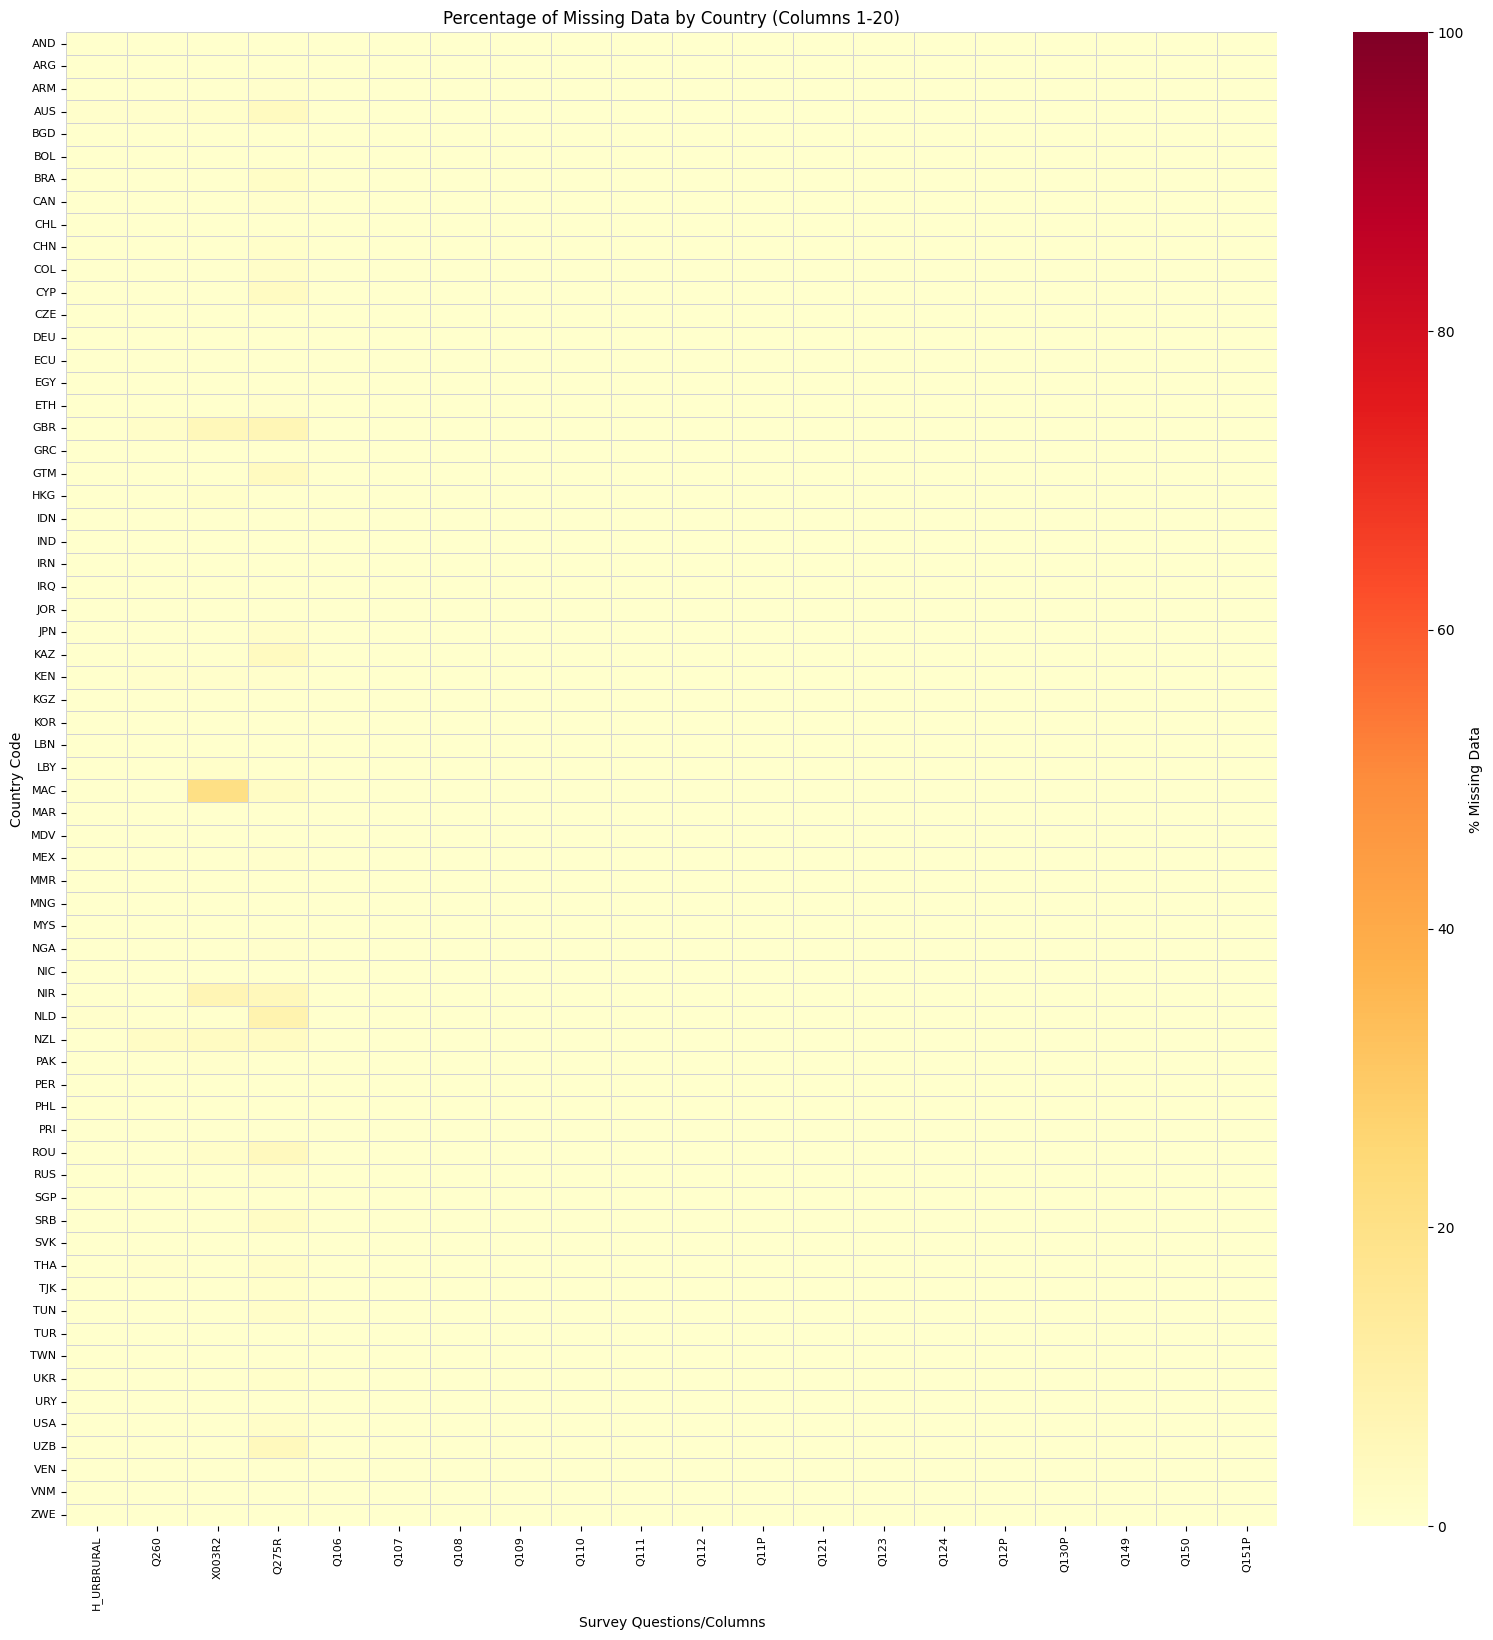

Saved detailed heatmap chunk 2 to: data\missing_data_heatmap_post_imputation_alternate_part_2.png


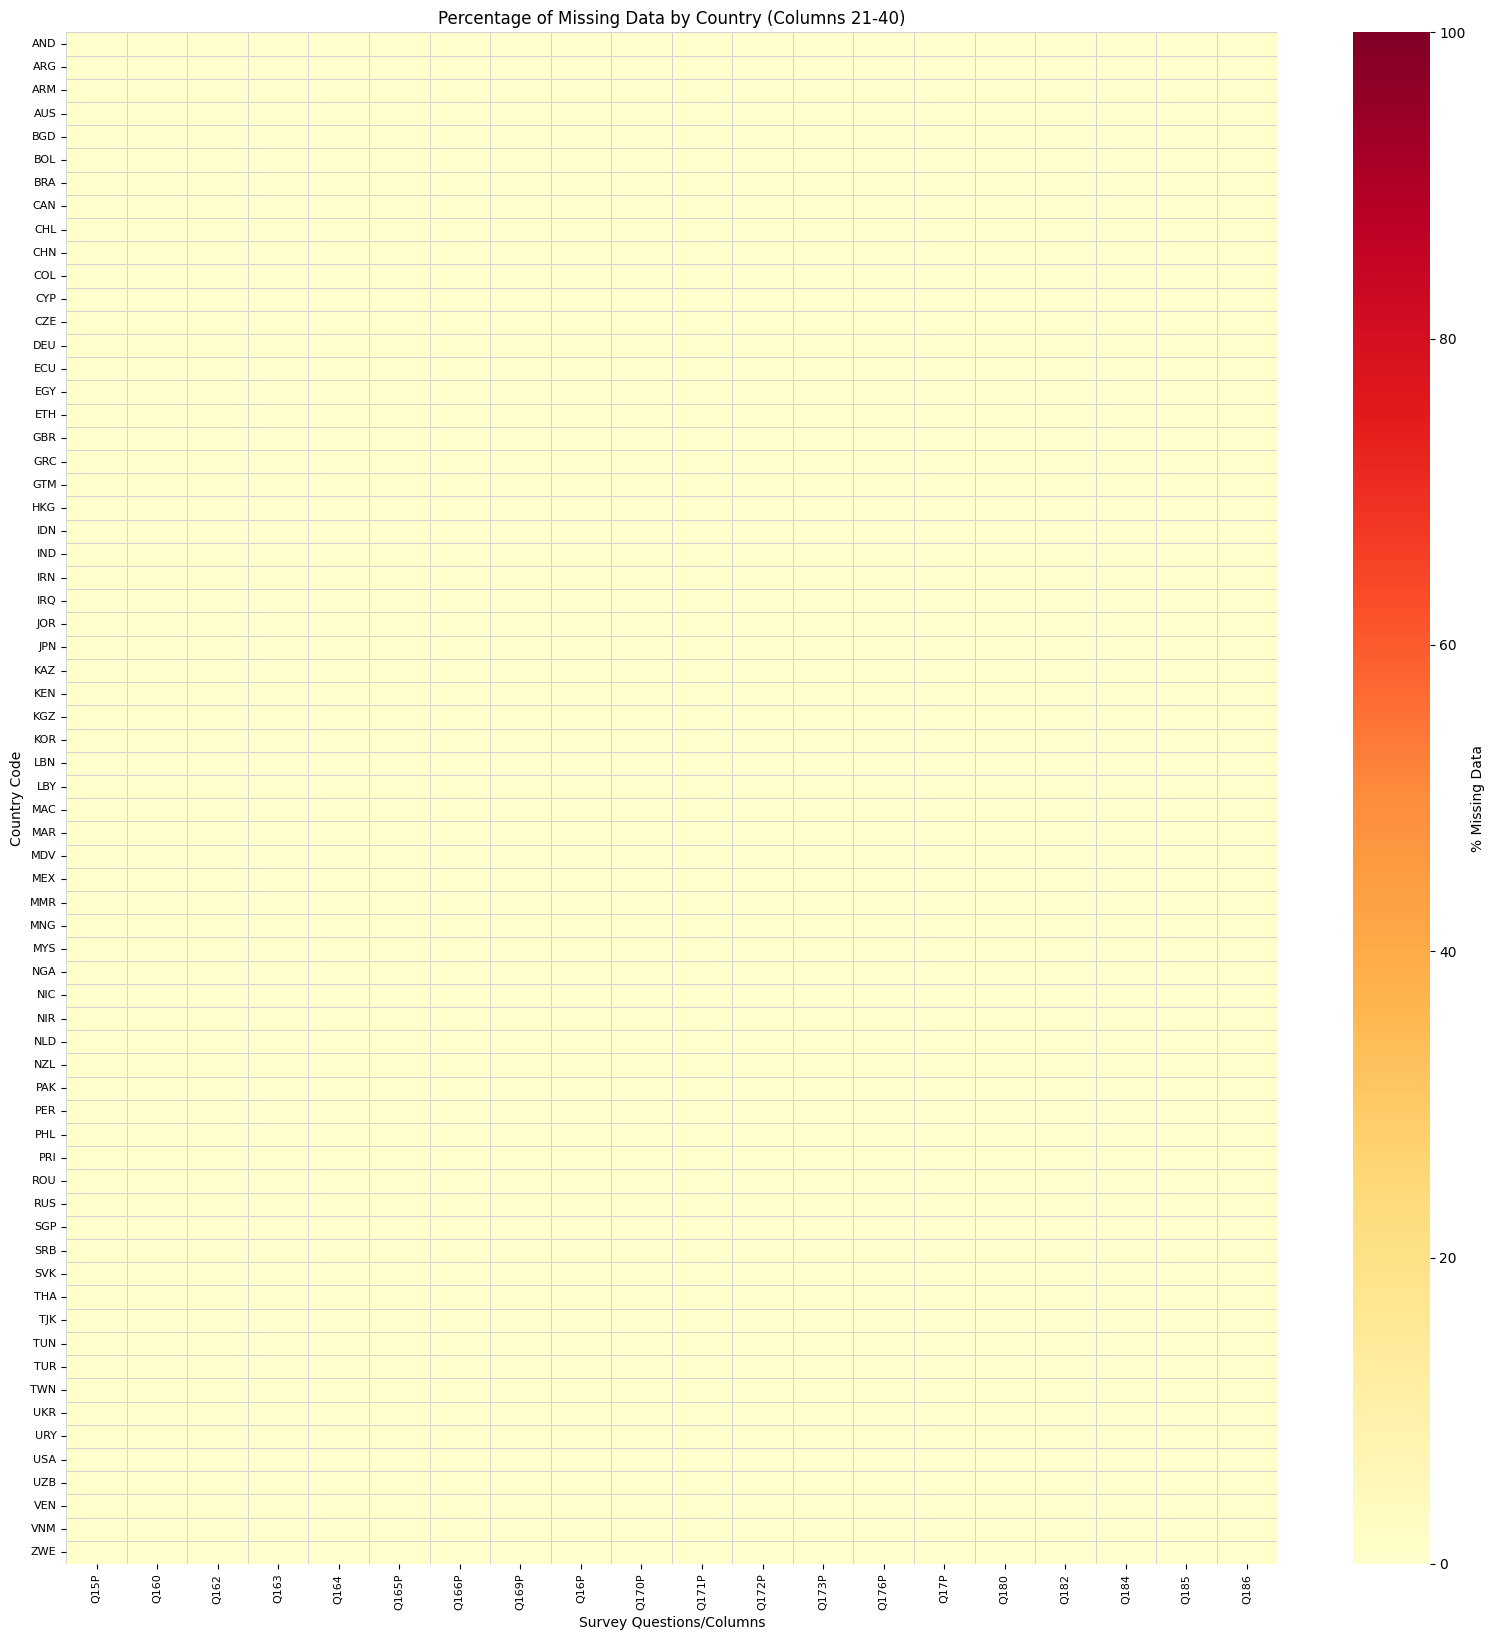

Saved detailed heatmap chunk 3 to: data\missing_data_heatmap_post_imputation_alternate_part_3.png


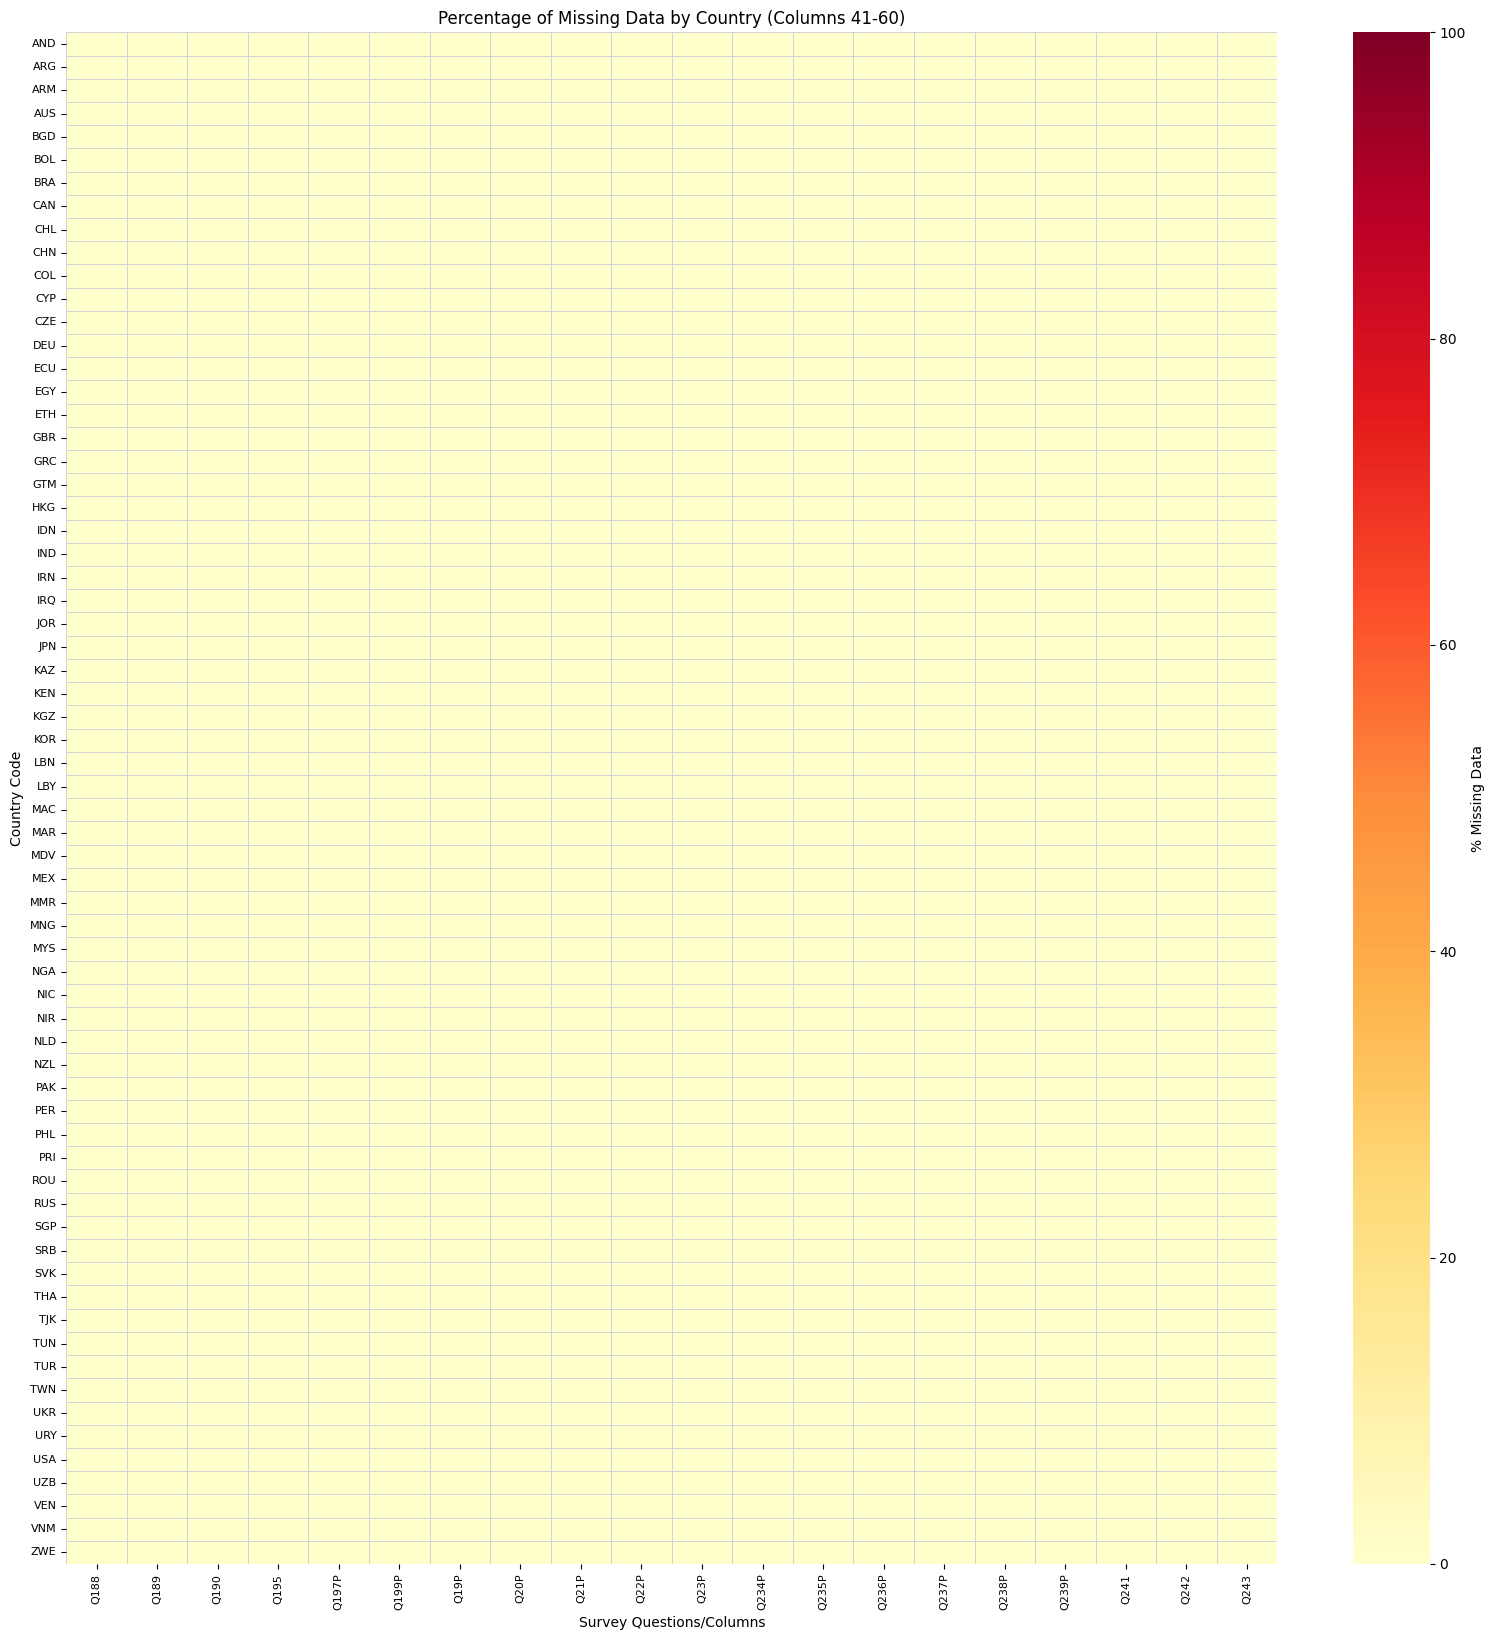

Saved detailed heatmap chunk 4 to: data\missing_data_heatmap_post_imputation_alternate_part_4.png


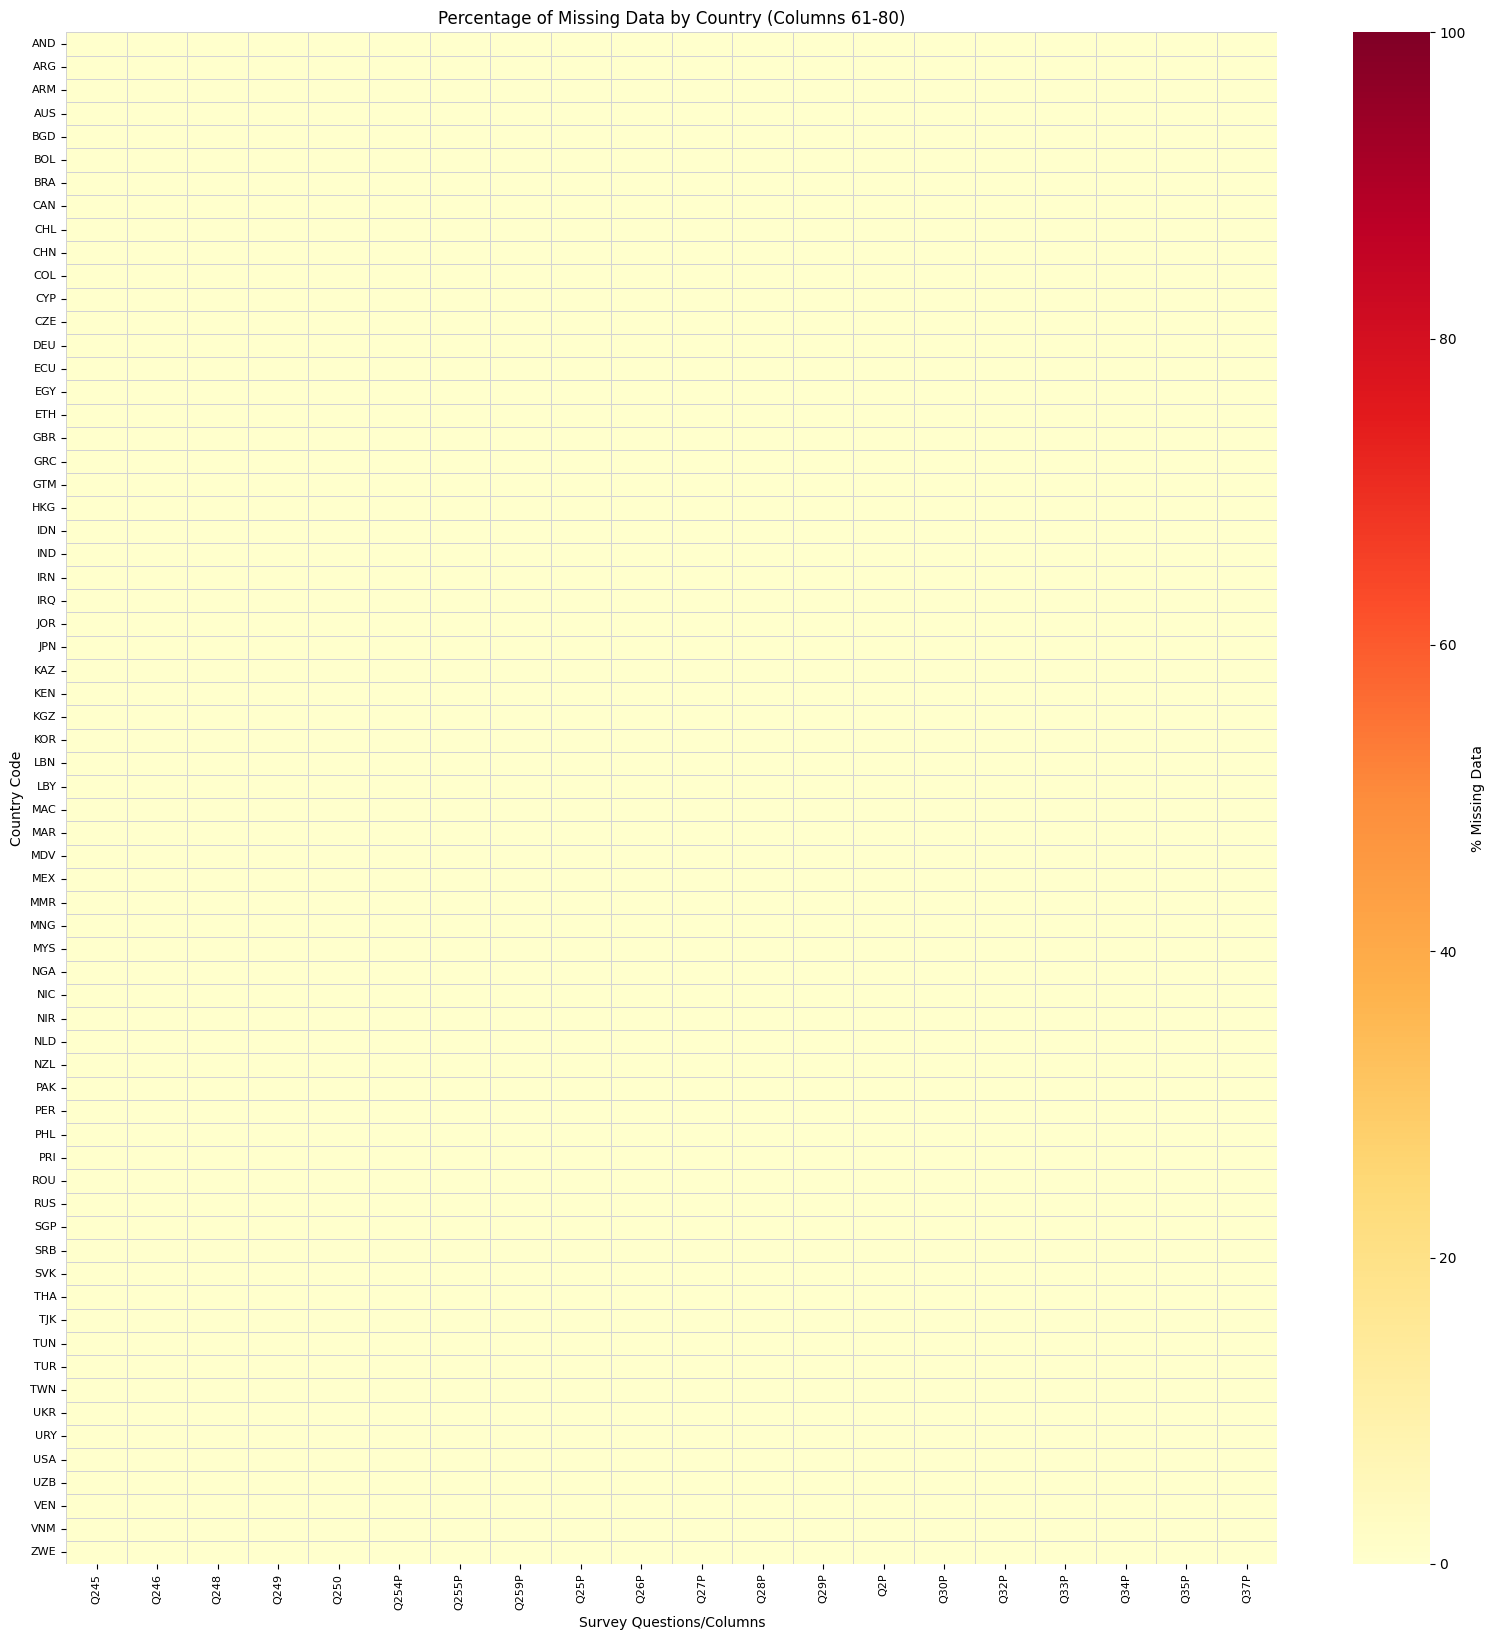

Saved detailed heatmap chunk 5 to: data\missing_data_heatmap_post_imputation_alternate_part_5.png


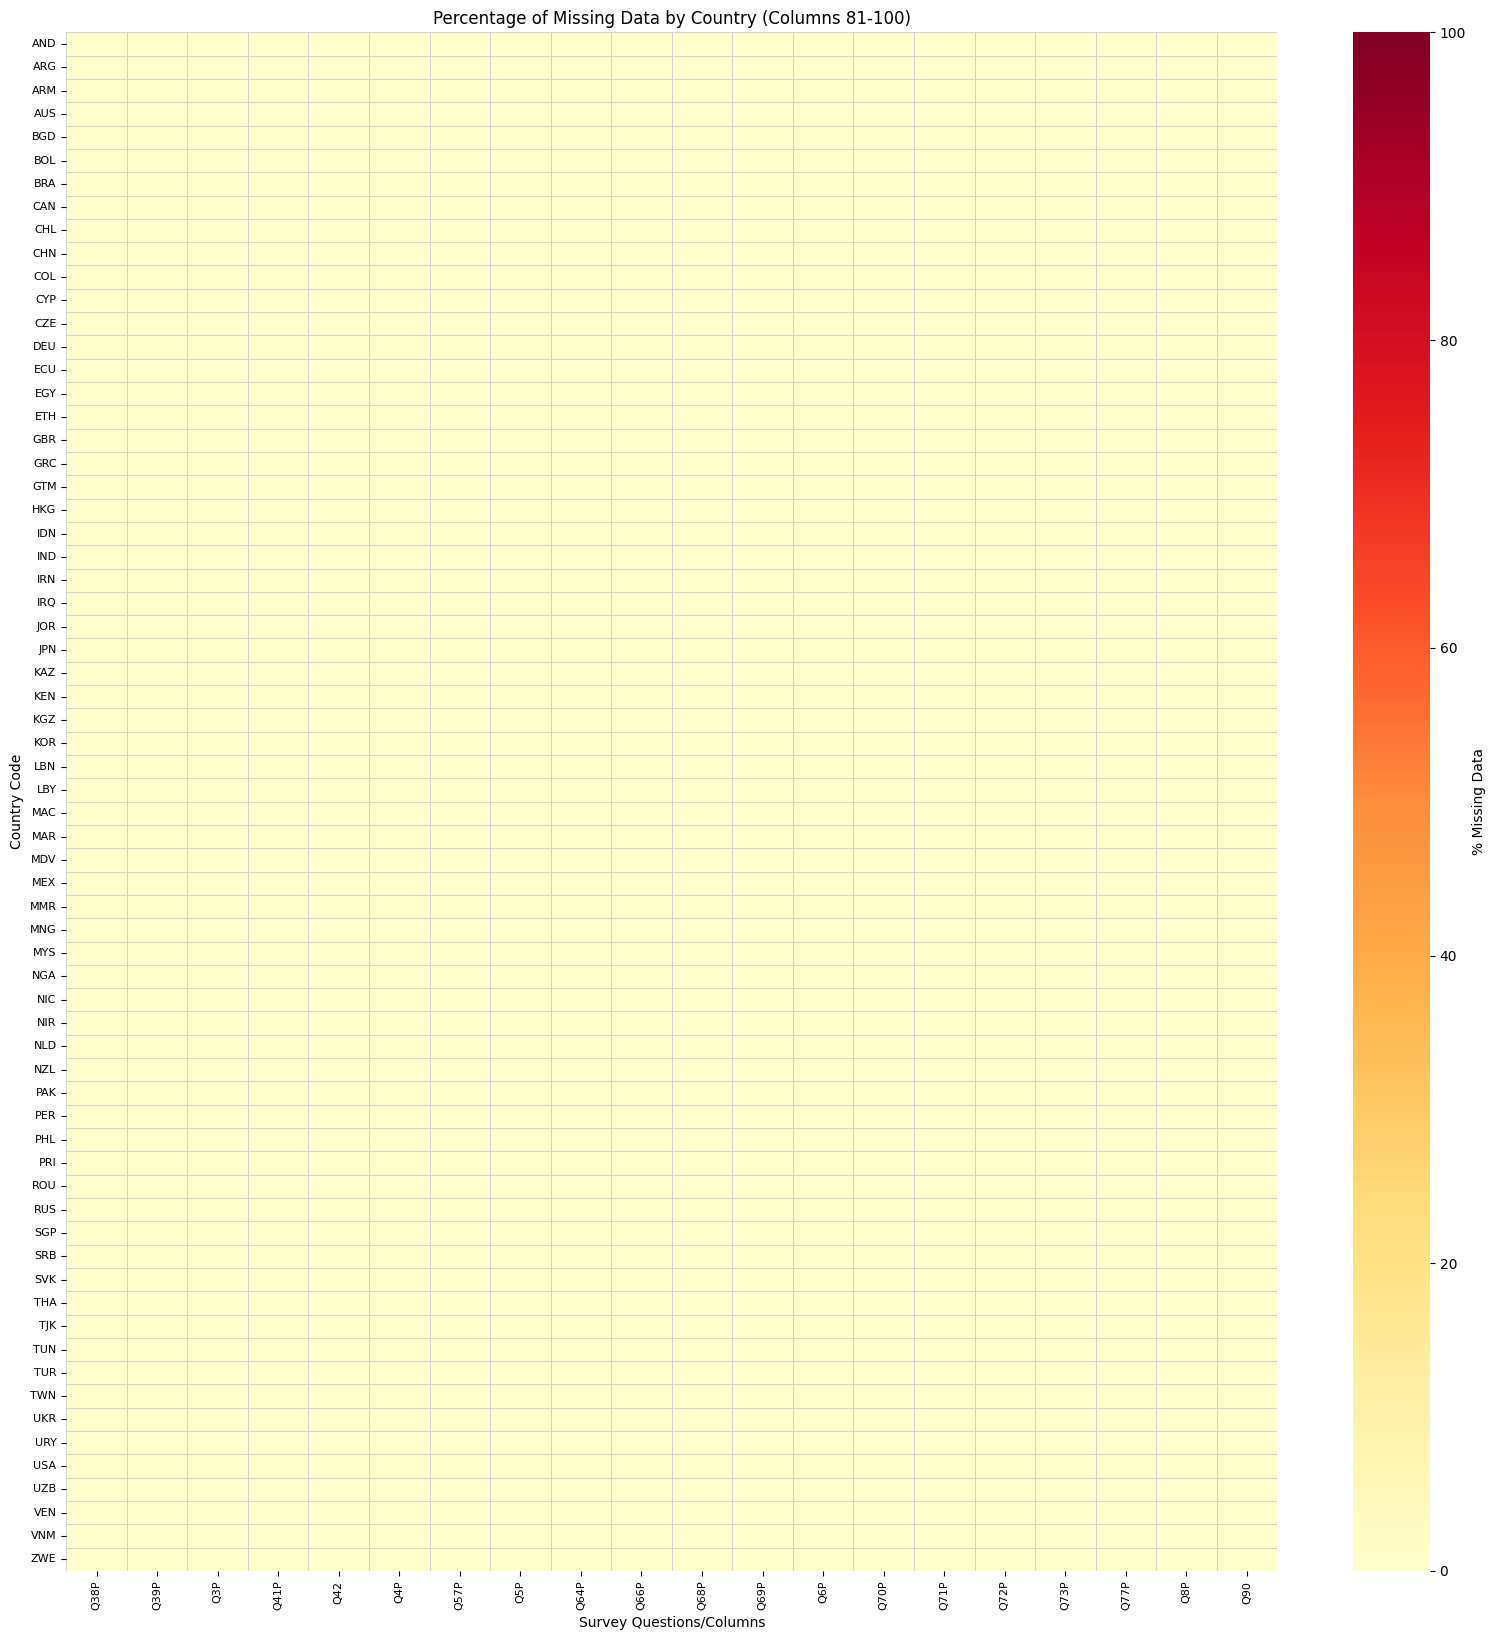

C:\Users\singh\AppData\Local\Temp\ipykernel_24744\634274217.py:304: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved detailed heatmap chunk 6 to: data\missing_data_heatmap_post_imputation_alternate_part_6.png


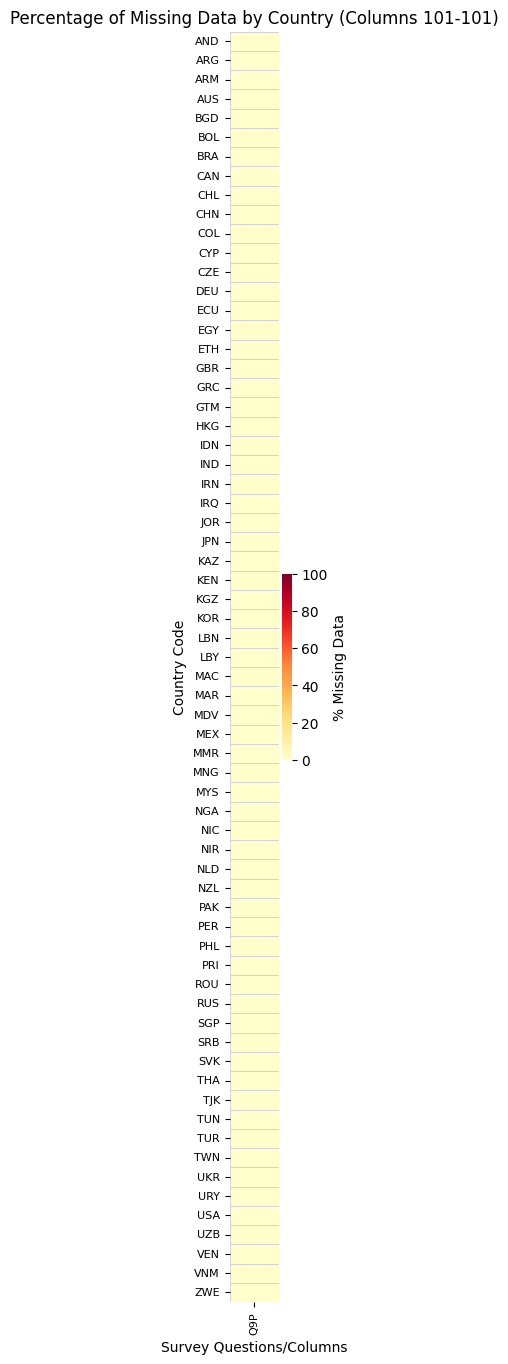


--- WVS Data Alternate Imputation Pipeline Finished ---


In [7]:
if __name__ == "__main__":
    main()

# Output
```python
=== Summary of Columns with Missing Data by Country (%) ===
         ≥0.1%_missing  ≥1%_missing  ≥5%_missing  ≥10%_missing  ≥25%_missing
Country                                                                     
AND                  0            0            0             0             0
ARG                  0            0            0             0             0
ARM                  1            0            0             0             0
AUS                  4            1            0             0             0
BGD                  0            0            0             0             0
...                ...          ...          ...           ...           ...
USA                  1            1            0             0             0
UZB                  1            1            0             0             0
VEN                  0            0            0             0             0
VNM                  0            0            0             0             0
ZWE                  2            0            0             0             0

[66 rows x 5 columns]

Generating summary heatmap of missing data counts...
Saved summary heatmap to: data\missing_data_summary_post_imputation_alternate.png
```